In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]

In [2]:
from darwinian_shift import DarwinianShift
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [3]:
from scipy.stats import linregress

# Setup

In [4]:
# Define the region to test
notch1_section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 'pdb_id': '2vj3', 'pdb_chain': 'A', 
    'start': 412, 'end': 488, # Restrict to the residues in EGF11-12
    'interface_residues': [413, 415, 418, 420, 421, 422, 423, 424, 425, 
                         435, 436, 444, 447, 448, 450, 451, 452, 454, 
                         466, 467, 468, 469, 470, 471, 475, 477, 478, 
                         479, 480],   # defined in Luca et al 2017
    'ca_binding_residues': [412, 413, 415, 431, 432, 435, 452, 453, 455, 469, 470]  # Defined by MetalPDB
}

In [5]:
d_skin = DarwinianShift(
    data = pd.read_excel('248092_3_supp_6645104_q35h43.xlsx', sheet_name='Table S4', skiprows=4),
    source_genome='GRCh37',
    spectra='skin_trinuc_spectrum.txt',
    included_mutation_types='missense'
)

In [6]:
d_oe = DarwinianShift(
    data=pd.read_excel('aau3879_TableS2.xlsx',
                       sheet_name='Mutations_collapsed_by_distance', skiprows=17),
    source_genome='GRCh37',
    spectra='oesophagus_trinuc_spectrum.txt',
    included_mutation_types='missense'
)

In [7]:
# Directories
sifts_directory="SIFTS_files"
pdb_directory = "PDB_files"



In [8]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="FoldX_results",
                   sifts_directory=sifts_directory,
                   foldx_file_name_start="PS_f*", download_sifts=True)

In [9]:
# Define a lookup object which determines whether mutations are on the NOTCH1-ligand interface. 
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

In [10]:
ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

In [11]:
destabilising_or_interface_or_calcium_lookup = ORLookup(
    lookups=[fold, interface_lookup, ca_lookup],  # Use the FoldX, interface and calcium lookups.  
    thresholds=[2, 0.5, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface and calcium results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are all 1.
)

# Mutation rate vs observed mutations

## Skin

In [12]:
s = d_skin.run_section(notch1_section_definition_egf11_12, lookup=destabilising_or_interface_or_calcium_lookup)
obs_counts = s.observed_mutations['ds_mut_id'].value_counts()
all_potential_mutations = s.null_mutations.copy()
all_potential_mutations['obs_count'] = all_potential_mutations.apply(
    lambda x: obs_counts.get(x['ds_mut_id'], 0), axis=1)

In [13]:
# Split mutations in any of the three categories from the rest
# The lookup score will be 1 for any of the categories, and 0 otherwise. 
all_potential_mutations_categories = all_potential_mutations[all_potential_mutations['score'] == 1]
all_potential_mutations_other = all_potential_mutations[all_potential_mutations['score'] == 0]

r-squared= 0.3559040376372226 p-value= 2.862725603366477e-36


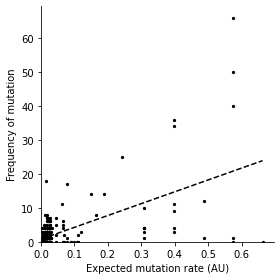

In [14]:
plt.figure(figsize=(4, 4))
x = all_potential_mutations_categories[d_skin.spectra[0].rate_column]
y = all_potential_mutations_categories['obs_count']
plt.scatter(x, y, c='k', s=5)
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print('r-squared=', r_value**2, 'p-value=', p_value)
plt.plot(np.unique(x), intercept + slope*np.unique(x), 'k--')
plt.ylabel('Frequency of mutation')
plt.xlabel('Expected mutation rate (AU)');
plt.xlim(left=0)
plt.ylim(bottom=0)
hide_top_and_right_axes()
plt.tight_layout()

r-squared= 0.13010241372246223 p-value= 4.6468875656715345e-06


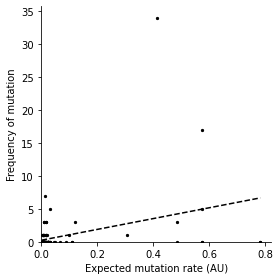

In [15]:
plt.figure(figsize=(4, 4))
x = all_potential_mutations_other[d_skin.spectra[0].rate_column]
y = all_potential_mutations_other['obs_count']
plt.scatter(x, y, c='k', s=5)
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print('r-squared=', r_value**2, 'p-value=', p_value)
plt.plot(np.unique(x), intercept + slope*np.unique(x), 'k--')
plt.ylabel('Frequency of mutation')
plt.xlabel('Expected mutation rate (AU)');
plt.xlim(left=0)
plt.ylim(bottom=0)
hide_top_and_right_axes()
plt.tight_layout()

## OE

In [16]:
s = d_oe.run_section(notch1_section_definition_egf11_12, lookup=destabilising_or_interface_or_calcium_lookup)
obs_counts = s.observed_mutations['ds_mut_id'].value_counts()
all_potential_mutations = s.null_mutations.copy()
all_potential_mutations['obs_count'] = all_potential_mutations.apply(
    lambda x: obs_counts.get(x['ds_mut_id'], 0), axis=1)

In [17]:
# Split mutations in any of the three categories from the rest
# The lookup score will be 1 for any of the categories, and 0 otherwise. 
all_potential_mutations_categories = all_potential_mutations[all_potential_mutations['score'] == 1]
all_potential_mutations_other = all_potential_mutations[all_potential_mutations['score'] == 0]

r-squared= 0.23896793120680693 p-value= 3.829210384066054e-23


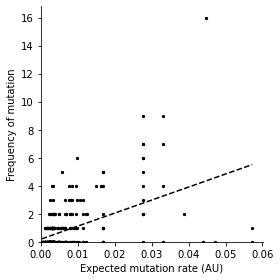

In [18]:
plt.figure(figsize=(4, 4))
x = all_potential_mutations_categories[d_oe.spectra[0].rate_column]
y = all_potential_mutations_categories['obs_count']
plt.scatter(x, y, c='k', s=5)
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print('r-squared=', r_value**2, 'p-value=', p_value)
plt.plot(np.unique(x), intercept + slope*np.unique(x), 'k--')
plt.ylabel('Frequency of mutation')
plt.xlabel('Expected mutation rate (AU)');
plt.xlim(left=0)
plt.ylim(bottom=0)
hide_top_and_right_axes()
plt.tight_layout()

r-squared= 0.04686181051406044 p-value= 0.007195765020770231


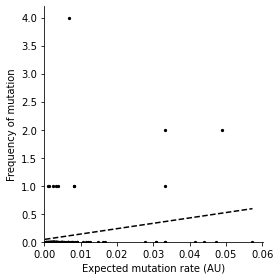

In [19]:
plt.figure(figsize=(4, 4))
x = all_potential_mutations_other[d_oe.spectra[0].rate_column]
y = all_potential_mutations_other['obs_count']
plt.scatter(x, y, c='k', s=5)
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print('r-squared=', r_value**2, 'p-value=', p_value)
plt.plot(np.unique(x), intercept + slope*np.unique(x), 'k--')
plt.ylabel('Frequency of mutation')
plt.xlabel('Expected mutation rate (AU)');
plt.xlim(left=0)
plt.ylim(bottom=0)
hide_top_and_right_axes()
plt.tight_layout()